Tutorials: https://github.com/argoai/argoverse-api/blob/master/demo_usage/

# Tracking

In [85]:
import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
import argoverse.visualization.visualization_utils as viz_util
from argoverse.utils.cv2_plotting_utils import plot_bbox_polygon_cv2

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [79]:
## set root_dir to the correct path to your dataset folder
root_dir =  '/Users/yuqingz/Downloads/argoverse-tracking/sample/'
loader = ArgoverseTrackingLoader(root_dir)

print('Total number of logs:',len(loader))
loader.print_all()

Total number of logs: 1
#images: 3439
#lidar: 156


Data are collected from self driving car session. Each session is called a log

In [80]:
# iterate over loader and print out statistics for each log
for i, data in enumerate(loader):
    if i >= 3:
        break
    print(data) 


--------------------------------------------------------------------
------Log id: c6911883-1843-3727-8eaa-41dc8cda8993
--------------------------------------------------------------------
Time: 15.500850000000002 sec
# frame lidar (@10hz): 156
# frame ring camera (@30hz): 469
# frame stereo camera (@5hz): 78

Total images: 3439
Total bounding box: 9337
        


In [81]:
# get data from each log
data = loader[0]
print(data)

data = loader.get('c6911883-1843-3727-8eaa-41dc8cda8993')
print(data)


--------------------------------------------------------------------
------Log id: c6911883-1843-3727-8eaa-41dc8cda8993
--------------------------------------------------------------------
Time: 15.500850000000002 sec
# frame lidar (@10hz): 156
# frame ring camera (@30hz): 469
# frame stereo camera (@5hz): 78

Total images: 3439
Total bounding box: 9337
        

--------------------------------------------------------------------
------Log id: c6911883-1843-3727-8eaa-41dc8cda8993
--------------------------------------------------------------------
Time: 15.500850000000002 sec
# frame lidar (@10hz): 156
# frame ring camera (@30hz): 469
# frame stereo camera (@5hz): 78

Total images: 3439
Total bounding box: 9337
        


## Visualization

Look at one specific log (log_id) at one frame (idx)

In [83]:
log_id = 'c6911883-1843-3727-8eaa-41dc8cda8993'#loader.log_list[55]
idx = 150

camera = loader.CAMERA_LIST[0]
data = loader.get(log_id)
city_name = data.city_name

In [84]:
loader.CAMERA_LIST

['ring_front_center',
 'ring_front_left',
 'ring_front_right',
 'ring_rear_left',
 'ring_rear_right',
 'ring_side_left',
 'ring_side_right',
 'stereo_front_left',
 'stereo_front_right']

annotations on images and 3D point clouds of objects around the egovehicle

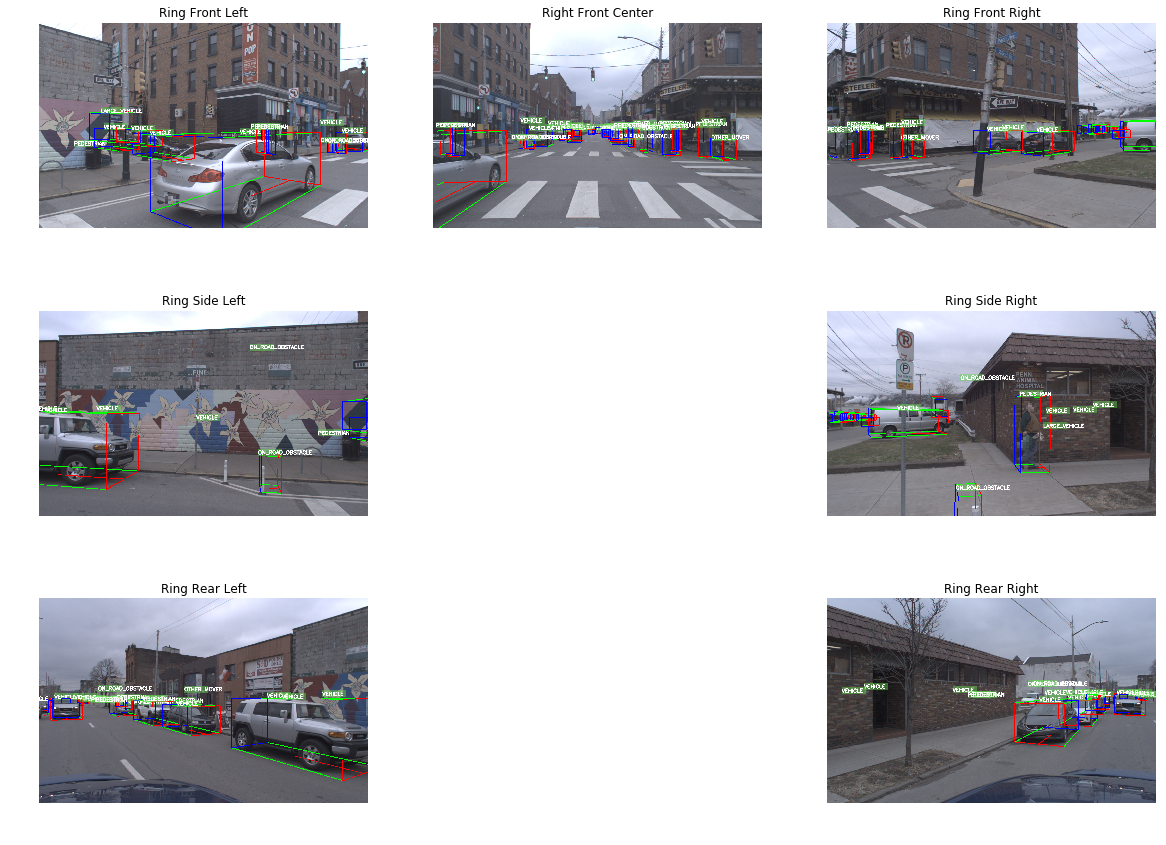

In [87]:
# ring cameras
f,ax = viz_util.make_grid_ring_camera(data,idx)
plt.show()

(-10.0, 10.0, -10.0, 10.0)

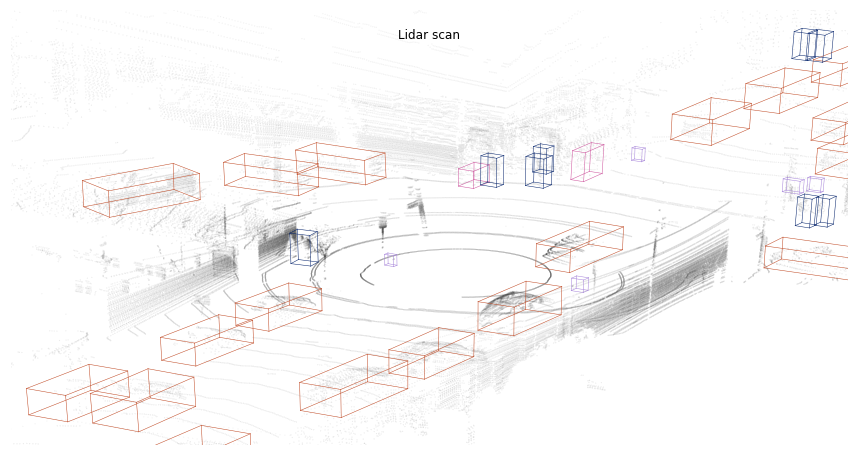

In [89]:
# point cloud
f2 = plt.figure(figsize=(15, 8))
ax2 = f2.add_subplot(111, projection='3d')
viz_util.draw_point_cloud(ax2, 'Lidar scan', data,idx)
ax2.axis('off')

## Syncronization

Frequency of lidar sensor output (10hz) is different than the camera's frame rate (30hz) - need to synchronize them

+ data.get_image_list returns list of all images at 30hz
+ data.get_image_list_sync returns a subset of image lists that sync with the lidar frames (10 hz)

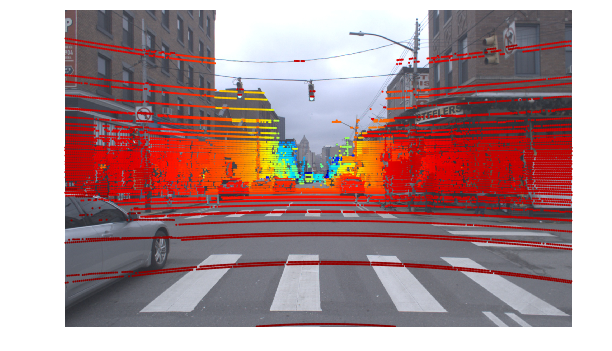

In [91]:
# Project point cloud into image
img = data.get_image_sync(idx, camera=camera)
objects = data.get_label_object(idx)
calib = data.get_calibration(camera)
img_vis = viz_util.show_image_with_boxes(img, objects, calib)
#display(Image.fromarray(img_vis))

pc = data.get_lidar(idx)
uv = calib.project_ego_to_image(pc).T
idx_ = np.where(np.logical_and.reduce((uv[0, :] >= 0.0, uv[0, :] < np.shape(img)[1] - 1.0,
                                                      uv[1, :] >= 0.0, uv[1, :] < np.shape(img)[0] - 1.0,
                                                      uv[2, :] > 0)))
idx_ = idx_[0]
uv1 =uv[:, idx_]

if uv1 is None:
    raise Exception('No point image projection')
    
plt.figure(figsize=(10,30))
plt.imshow(img)
cm = plt.cm.get_cmap('jet')
plt.scatter(uv1[0], uv1[1], c=1 - uv1[2] / max(uv1[2]), s=1, cmap=cm)
plt.axis('off')
plt.show()

## Track object through time

Each object is marked with a unique tracking id

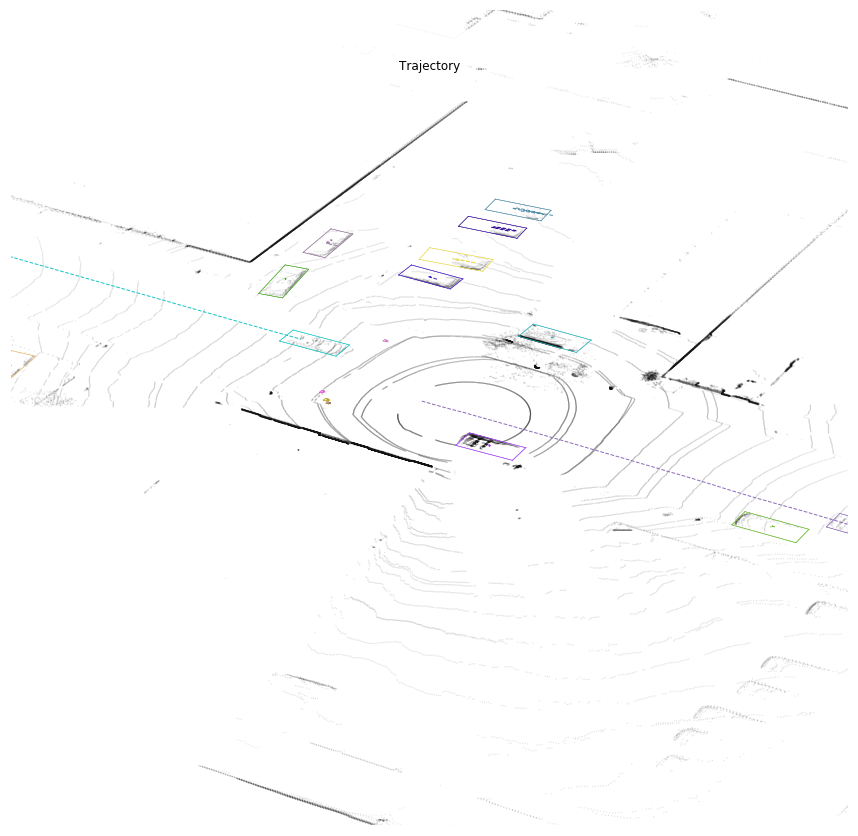

In [92]:
f3 = plt.figure(figsize=(15, 15))
ax3 = f3.add_subplot(111, projection='3d')  
idx=30 # current time frame
viz_util.draw_point_cloud_trajectory(
        ax3, 
        'Trajectory', 
        data,idx,axes=[0, 1],xlim3d=(-15,15),ylim3d=(-15,15) # X and Y axes
    )
plt.axis('off')
plt.show()

# Map

In [74]:
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
import argoverse.visualization.visualization_utils as viz_util
from argoverse.utils.frustum_clipping import generate_frustum_planes
from argoverse.visualization.ground_visualization import draw_ground_pts_in_image

from shapely.geometry.polygon import Polygon 
from PIL import Image 
import matplotlib
import matplotlib.pyplot as plt
import logging
import copy

from visualize_30hz_benchmark_data_on_map import DatasetOnMapVisualizer
from cuboids_to_bboxes import plot_lane_centerlines_in_img

In [58]:
avm = ArgoverseMap()
loader = ArgoverseTrackingLoader('/Users/yuqingz/Downloads/argoverse-tracking/sample/')

## Coordinates

+ Map: city coordinates
+ Tracking data: egovehicle coordinate

## Lane Polygon

Retrieve polygon of lanes in the specified area: get a city coordinate of the car from log 0, frame 10, and show the first 5 lane polygons within 60 meters around the cars.

In [14]:
len(loader)

1

In [10]:
loader.log_list  # list of logs

['c6911883-1843-3727-8eaa-41dc8cda8993']

In [35]:
log_index = 0
frame_index = 10
N_lanes = 5
radius = 60
lidar_index = 100  # lidar index

In [18]:
log_id = loader.log_list[log_index]
data = loader[log_index]
data.city_name

'PIT'

In [51]:
data.current_log

'c6911883-1843-3727-8eaa-41dc8cda8993'

In [24]:
data._lidar_timestamp_list  # list of lidar index associated with each log

{'c6911883-1843-3727-8eaa-41dc8cda8993': [315978406019574000,
  315978406119770000,
  315978406219967000,
  315978406320163000,
  315978406420359000,
  315978406519892000,
  315978406620088000,
  315978406720284000,
  315978406819817000,
  315978406920013000,
  315978407020448000,
  315978407119981000,
  315978407220177000,
  315978407319710000,
  315978407419906000,
  315978407520103000,
  315978407619635000,
  315978407719832000,
  315978407820028000,
  315978407920224000,
  315978408020424000,
  315978408120620000,
  315978408220153000,
  315978408320349000,
  315978408420546000,
  315978408520742000,
  315978408620275000,
  315978408720471000,
  315978408820003000,
  315978408920200000,
  315978409020400000,
  315978409119933000,
  315978409220129000,
  315978409320325000,
  315978409419858000,
  315978409520054000,
  315978409620250000,
  315978409719783000,
  315978409819979000,
  315978409920175000,
  315978410019481000,
  315978410119677000,
  315978410219874000,
  315978410320

In [28]:
data.get_lidar(lidar_index)

array([[ 0.96052897, -4.0975075 , -0.32992208],
       [ 1.35404   , -7.290826  ,  1.4632006 ],
       [ 0.6365929 , -7.30378   ,  1.3768786 ],
       ...,
       [-0.56419253,  7.1339626 , -0.52878034],
       [-1.905992  ,  9.649342  , -0.40125108],
       [-1.8956823 , 11.258459  ,  1.7546287 ]], dtype=float32)

In [29]:
# convert egovehicle coordinate into city coordinate
x, y, _ = data.get_pose(frame_index).translation

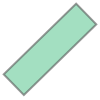

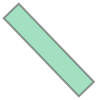

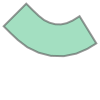

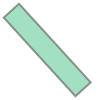

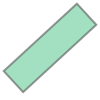

In [37]:
area = [x-radius/2, x+radius/2, y-radius/2, y+radius/2]
for i in range(N_lanes):
    display(Polygon(avm.find_local_lane_polygons(area, data.city_name)[i]))

In [46]:
len(avm.find_local_lane_polygons(area, data.city_name))  # 26 lanes in specified area

26

## Driveable area

In [45]:
len(avm.find_local_driveable_areas(area, data.city_name))  # 5 drivable areas in specified area

5

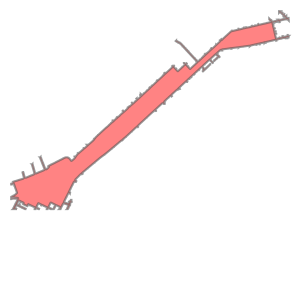

In [44]:
display(Polygon(avm.find_local_driveable_areas(area, data.city_name)[0]))

## Visualize data on map

In [62]:
# Map from a bird's-eye-view (BEV)
dataset_dir = '/Users/yuqingz/Downloads/argoverse-tracking/sample/'
experiment_prefix = 'visualization_demo'

#if you are running for the first time, or using a new set of logs, 
# this will need to be set False to accumelate the labels again
use_existing_files = False

city_to_egovehicle_se3 = data.get_pose(frame_index)   # egovehicle coordinates

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

domv = DatasetOnMapVisualizer(dataset_dir, experiment_prefix, 
                              use_existing_files=use_existing_files, log_id=data.current_log)

In [69]:
# city_to_egovehicle_se3 # SE3 class, allows point cloud rotation and translation operations

### Overlay label annotation on top of map

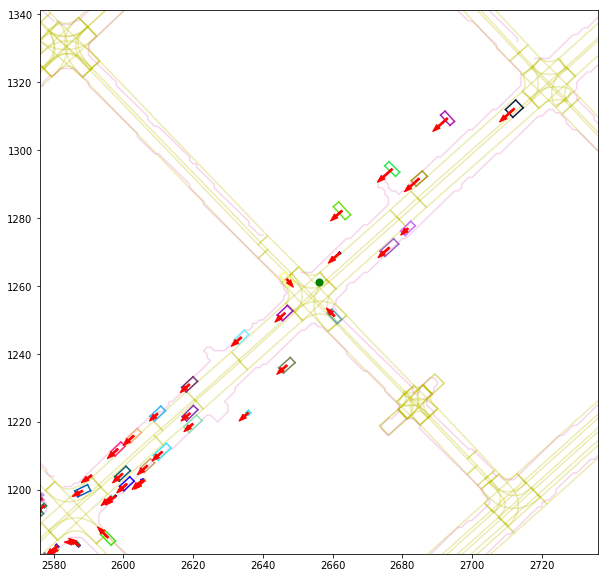

In [63]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

xcenter,ycenter,_ = data.get_pose(frame_index).translation  # city coordinate
    
xmin = xcenter - 80  # 150
xmax = xcenter + 80  # 150
ymin = ycenter - 80  # 150
ymax = ycenter + 80  # 150

ax.scatter(xcenter, ycenter, 200, color="g", marker=".", zorder=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
local_lane_polygons = avm.find_local_lane_polygons([xmin, xmax, ymin, ymax], data.city_name)
local_das = avm.find_local_driveable_areas([xmin, xmax, ymin, ymax], data.city_name)

domv.render_bev_labels_mpl(
    data.city_name,
    ax, # figure axis
    "city_axis",  # using city coordinates
    None,   # lidar points
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,    # log ID
    data.lidar_timestamp_list[lidar_index],  # lidar timestamp
    city_to_egovehicle_se3,
    avm,  
)

### Overlay map on top of lidar point clouds

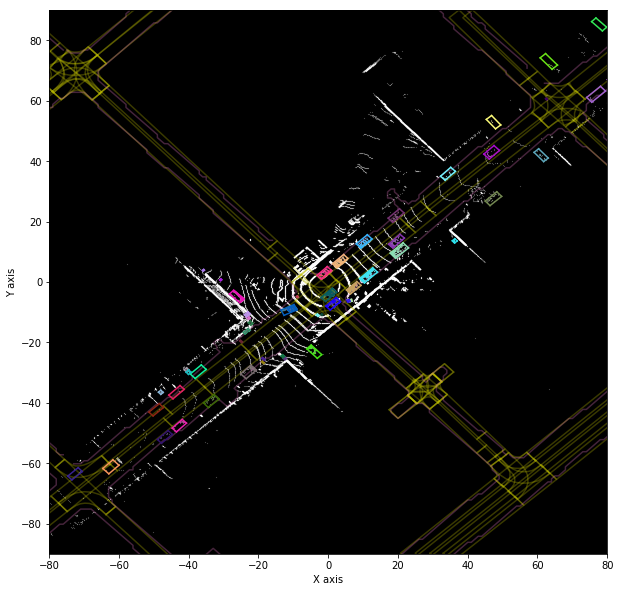

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

lidar_pts = data.get_lidar(lidar_index)

domv.render_bev_labels_mpl(
    data.city_name,
    ax, # figure axis
    "ego_axis",  # using city coordinates
    lidar_pts,   # lidar points
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,    # log ID
    data.lidar_timestamp_list[lidar_index],  # lidar timestamp
    city_to_egovehicle_se3,
    avm
)

### Remove points outside of driveable area

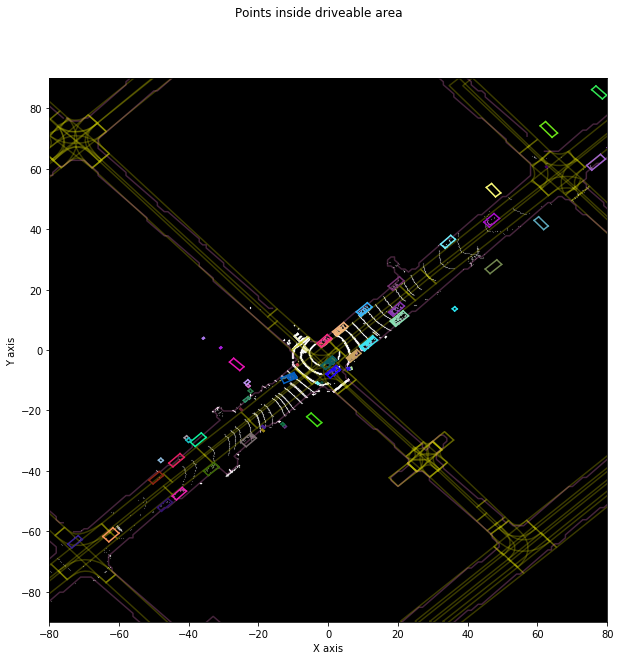

In [68]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Points inside driveable area')
ax = fig.add_subplot(111)

driveable_area_pts = copy.deepcopy(lidar_pts)
driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    driveable_area_pts
)  # put into city coords
driveable_area_pts = avm.remove_non_driveable_area_points(driveable_area_pts, data.city_name)
driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    driveable_area_pts
)  # put back to ego coords

domv.render_bev_labels_mpl(
    data.city_name,
    ax,
    "ego_axis",
    driveable_area_pts,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,
    data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    avm,
)

### Remove points bloinging to the ground surface

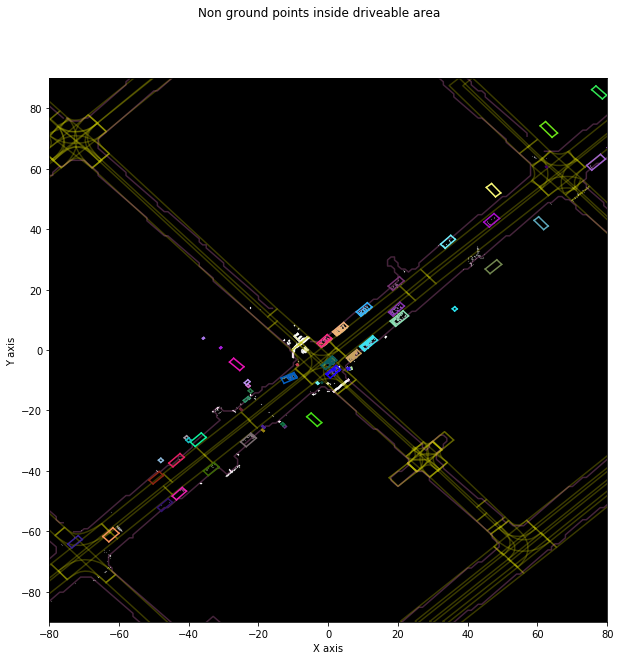

In [71]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Non ground points inside driveable area')
ax = fig.add_subplot(111)

driveable_area_pts = copy.deepcopy(lidar_pts)
driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    driveable_area_pts
)  # put into city coords
driveable_area_pts = avm.remove_non_driveable_area_points(driveable_area_pts, data.city_name)
driveable_area_pts = avm.remove_ground_surface(driveable_area_pts, data.city_name)
driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    driveable_area_pts
)

domv.render_bev_labels_mpl(
    data.city_name,
    ax,
    "ego_axis",
    driveable_area_pts,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,
    data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    avm,
)

### Overlay labels & lidar points on images

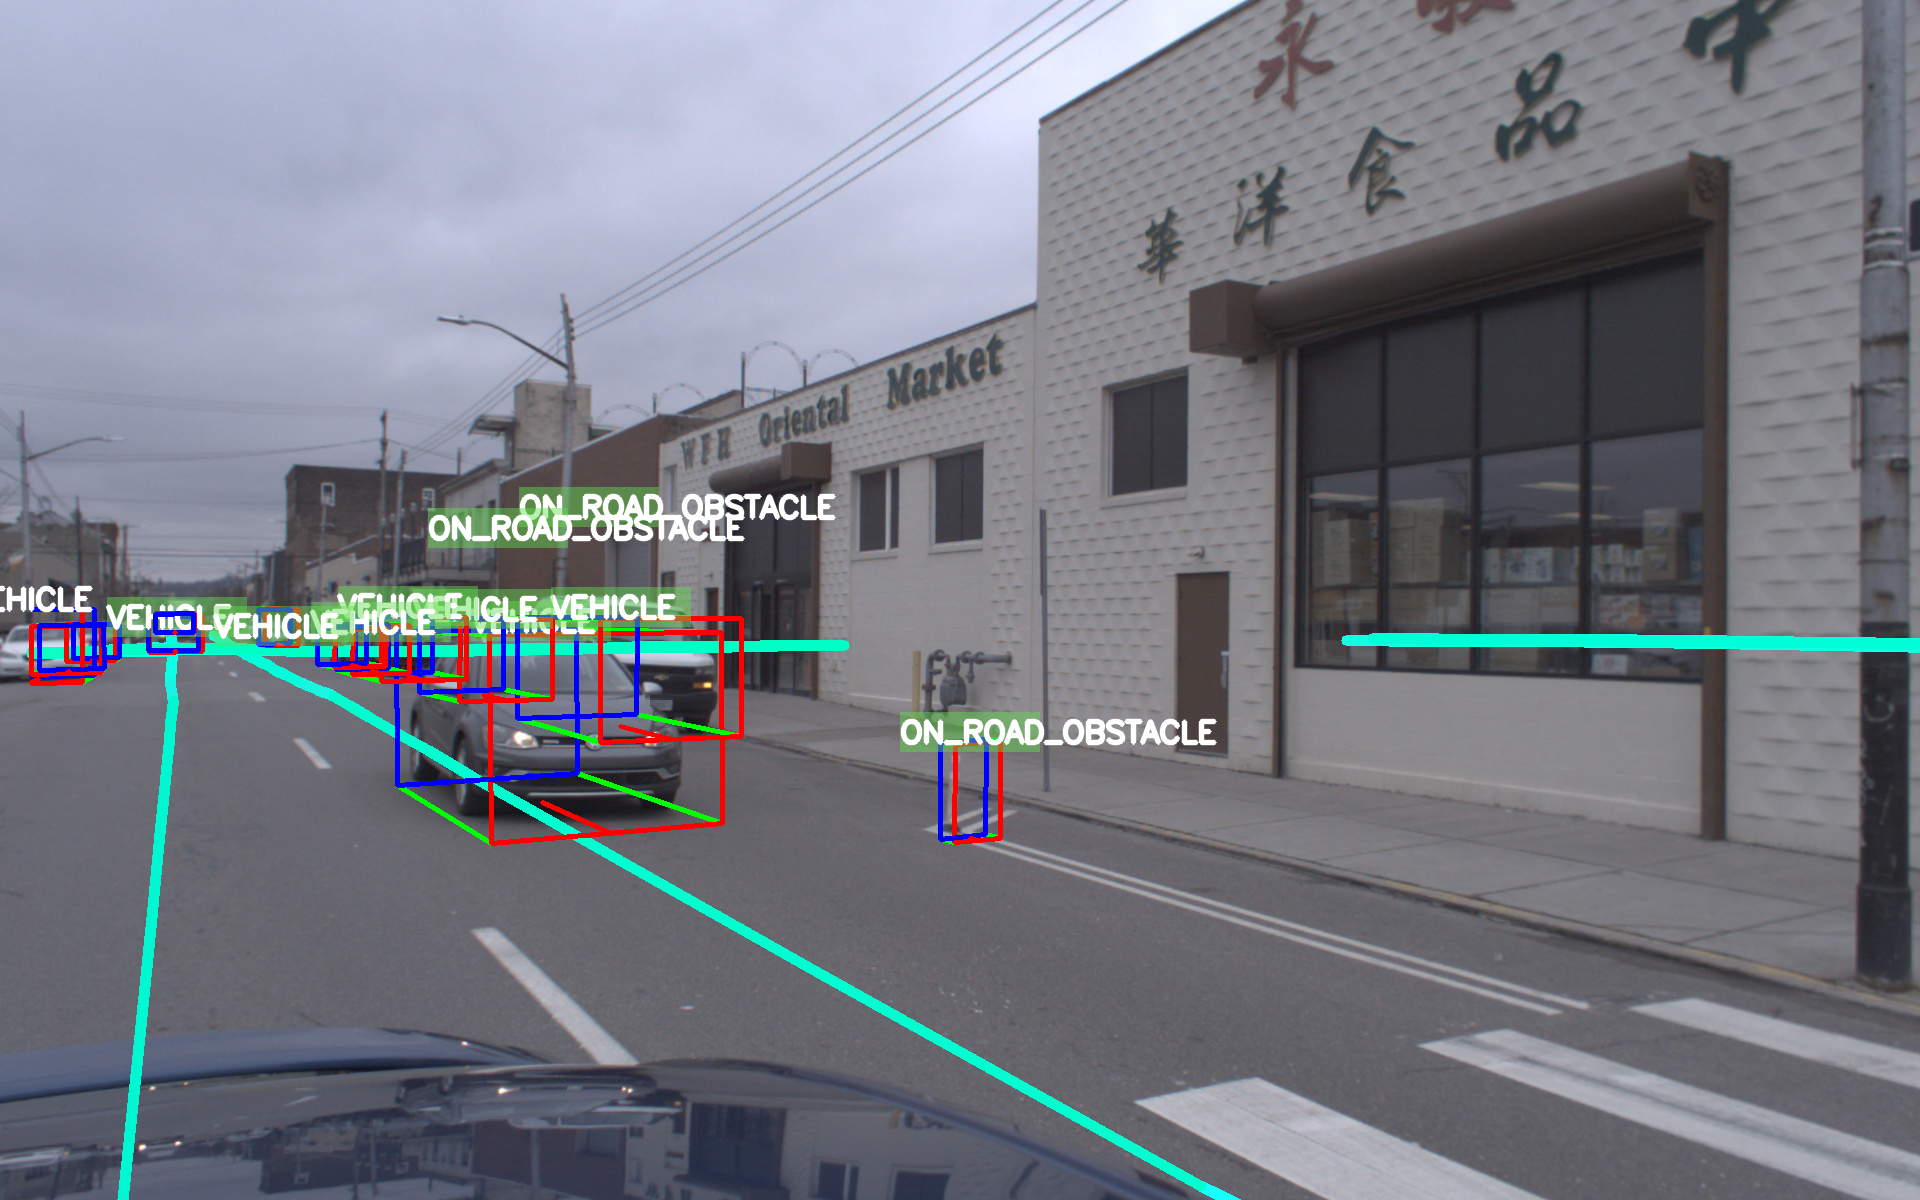

In [73]:
camera = 'ring_rear_left'

img = data.get_image_sync(frame_index, camera = camera)
objects = data.get_label_object(frame_index)
calib = data.get_calibration(camera)

lidar_pts = data.get_lidar(lidar_index)
calib = data.get_calibration(camera=camera)
planes = generate_frustum_planes(calib.camera_config.intrinsic.copy(), camera)

img_wlane = plot_lane_centerlines_in_img(lidar_pts, city_to_egovehicle_se3, img, 
                                         data.city_name, avm, calib.camera_config, planes)
#display(Image.fromarray(img_wlane))
img_vis = viz_util.show_image_with_boxes(img_wlane,objects,calib)
display(Image.fromarray(img_vis))

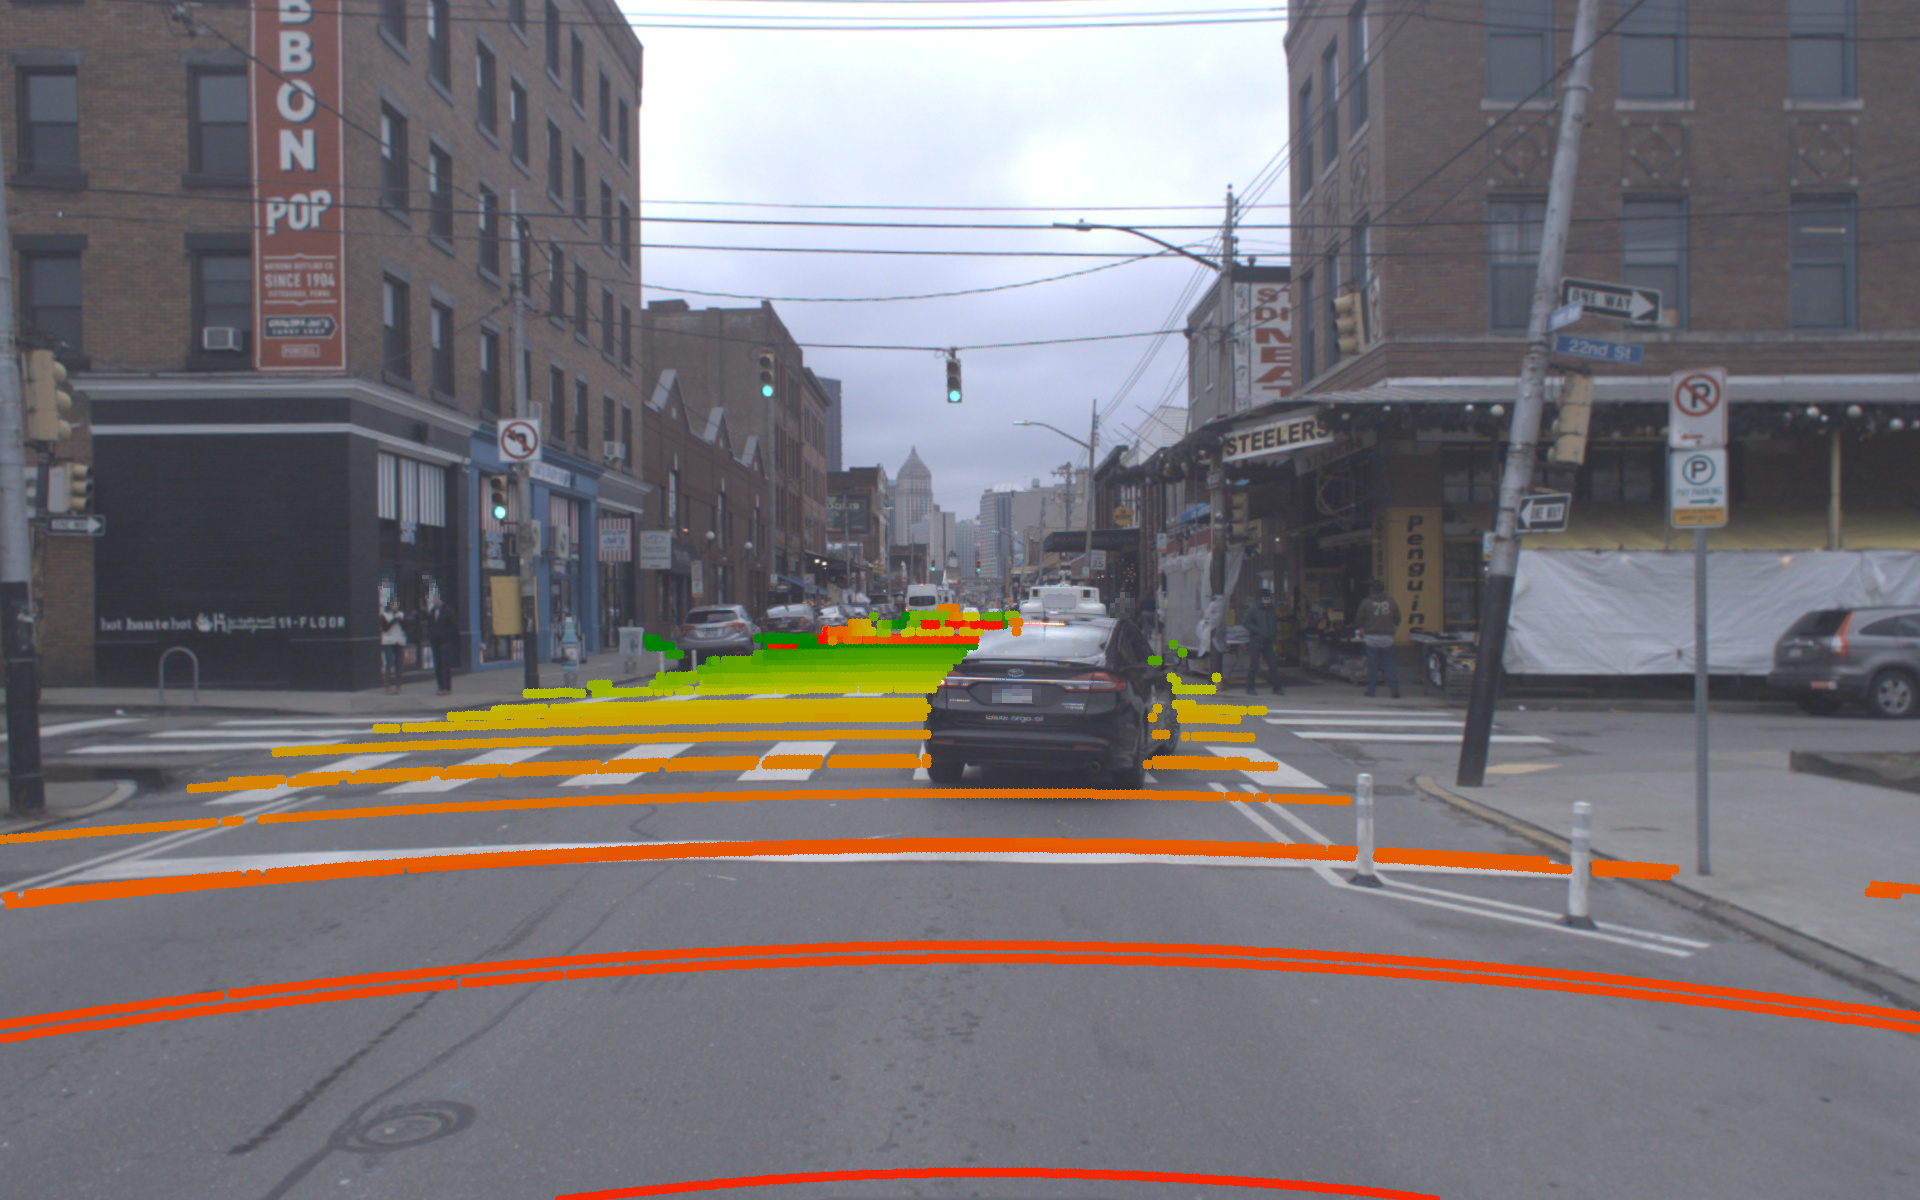

In [75]:
img = draw_ground_pts_in_image(
            data.sync,
            lidar_pts,
            city_to_egovehicle_se3,
            avm,
            log_id,
            data.lidar_timestamp_list[lidar_index],
            data.city_name,
            dataset_dir,
            experiment_prefix,
            camera = 'ring_front_center'
        )

display(Image.fromarray(img))

# Competition tracking pipeline (old)

In [93]:
import copy
import numpy as np
import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from argoverse.map_representation.map_api import ArgoverseMap

#path to argoverse tracking dataset test set, we will add our predicted labels into per_sweep_annotations_amodal/ 
#inside this folder
data_dir = '/Users/yuqingz/Downloads/argoverse-tracking/sample/'
argoverse_loader = ArgoverseTrackingLoader(data_dir)
am = ArgoverseMap()

In [96]:
#load up example scene
argoverse_data = argoverse_loader[0]

#load up info
idx = 0
lidar_pts = argoverse_data.get_lidar(idx)
city_to_egovehicle_se3 = argoverse_data.get_pose(idx)
city_name = argoverse_data.city_name

In [97]:
# first remove points that lie outside of region of interest (ROI). 
# Additionally, we will also remove points that belong to the ground surface. 
# Now the remaining points should be a lot more likely to be an object
roi_area_pts = copy.deepcopy(lidar_pts)
roi_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    roi_area_pts
)  # put into city coords
roi_area_pts = am.remove_non_roi_points(roi_area_pts, city_name)
roi_area_pts = am.remove_ground_surface(roi_area_pts, city_name)
roi_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    roi_area_pts
)

In [98]:
# further separate the points that are inside driveable area vs points that are 
# outside driveable area (but still within our region of interest)
driveable_area_pts = copy.deepcopy(roi_area_pts)
driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    driveable_area_pts
)  # put into city coords
driveable_area_pts = am.remove_non_driveable_area_points(driveable_area_pts, city_name)
driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    driveable_area_pts
)

roi_area_pts_hashable = map(tuple,roi_area_pts)
driveable_area_pts_hashable = map(tuple,driveable_area_pts)
non_driveable_area_pts = np.array(list(set(roi_area_pts_hashable) - set(driveable_area_pts_hashable)))

In [99]:
# perform clustering on the 3D points. Here we use DBSCAN from sklearn. 
# We can filter out clusters that are likely to be our target with some 
# simple heuristics. For example, a car should not be higher than 2 meters, 
# and car length should be between 3-7 meters

In [106]:
# positions of likely objects in this particular frame
import matplotlib
import matplotlib.pyplot as plt
import argoverse.visualization.visualization_utils as viz_util
import quaternion
from argoverse.evaluation.competition_util import get_polygon_from_points, poly_to_label

from sklearn.cluster import DBSCAN

clustering_car = DBSCAN(eps=0.7, min_samples=15, leaf_size=15).fit(driveable_area_pts)
clustering_people = DBSCAN(eps=1, min_samples=5, leaf_size=15).fit(non_driveable_area_pts)

core_samples_mask_car = np.zeros_like(clustering_car.labels_, dtype=bool)
core_samples_mask_car[clustering_car.core_sample_indices_] = True
labels_car = clustering_car.labels_

core_samples_mask_people = np.zeros_like(clustering_people.labels_, dtype=bool)
core_samples_mask_people[clustering_people.core_sample_indices_] = True
labels_people = clustering_people.labels_


point_size = 0.3

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection='3d')
unique_labels_car = set(labels_car)
colors = [np.random.rand(3,) for i in np.linspace(0, 1, len(unique_labels_car))]
for k, col in zip(unique_labels_car, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask_car = (labels_car == k)
    xyz = driveable_area_pts[class_member_mask_car & core_samples_mask_car]
    if len(xyz) > 20:
        poly = get_polygon_from_points(xyz)
        label = poly_to_label(poly)
        if label.length < 7 and label.length > 1 and label.height < 2.5:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker=".", s=point_size)
            viz_util.draw_box(ax, label.as_3d_bbox().T, axes=[0, 1, 2], color=col)
        else:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[[1,1,1,1]], marker=".", s=0.01)
            

unique_labels_people = set(labels_people)
colors = [np.random.rand(3,) for i in np.linspace(0, 1, len(unique_labels_people))]
for k, col in zip(unique_labels_people, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask_people = (labels_people == k)
    xyz = non_driveable_area_pts[class_member_mask_people & core_samples_mask_people]
    if len(xyz) > 10:
        poly = get_polygon_from_points(xyz)
        label = poly_to_label(poly)
        if label.width < 1 and label.length < 1 and label.height > 1 and label.height < 2.5:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker=".", s=point_size)
            viz_util.draw_box(ax, label.as_3d_bbox().T, axes=[0, 1, 2], color=col)
        else:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[[1,1,1,1]], marker=".", s=0.01)

ax.set_xlim3d([-10, 10])
ax.set_ylim3d([-10, 10])
ax.set_zlim3d([-3, 10])

ax.set_facecolor((0, 0, 0))
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'quaternion'

In [ ]:
# tracking: detect objects in each frame separately and then attempt to associate them into tracks 
from argoverse.evaluation.competition_util import get_polygon_from_points, poly_to_label, save_label, get_objects, transform_xyz
from sklearn.cluster import DBSCAN

def tracking(argoverse_data):
    
    num_frames = argoverse_data.num_lidar_frame

    lidar_pts = argoverse_data.get_lidar(0)
    city_to_egovehicle_se3 = argoverse_data.get_pose(0)
    city_name = argoverse_data.city_name

    roi_area_pts = copy.deepcopy(lidar_pts)
    roi_area_pts = city_to_egovehicle_se3.transform_point_cloud(
        roi_area_pts
    )  # put into city coords
    roi_area_pts = am.remove_non_roi_points(roi_area_pts, city_name)
    roi_area_pts = am.remove_ground_surface(roi_area_pts, city_name)
    roi_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
        roi_area_pts
    )

    driveable_area_pts = copy.deepcopy(roi_area_pts)
    driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
        driveable_area_pts
    )  # put into city coords
    driveable_area_pts = am.remove_non_driveable_area_points(driveable_area_pts, city_name)
    driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
        driveable_area_pts
    )

    roi_area_pts_hashable = map(tuple,roi_area_pts)
    driveable_area_pts_hashable = map(tuple,driveable_area_pts)
    non_driveable_area_pts = np.array(list(set(roi_area_pts_hashable) - set(driveable_area_pts_hashable)))

    clustering_car = DBSCAN(eps=0.7, min_samples=15, leaf_size=15).fit(driveable_area_pts)
    clustering_people = DBSCAN(eps=1, min_samples=5, leaf_size=15).fit(non_driveable_area_pts)

    car_objects = get_objects(clustering_car,driveable_area_pts)
    people_objects = get_objects(clustering_people,non_driveable_area_pts)

    for idx in range(num_frames):
        pose = argoverse_data.get_pose(idx)
        labels = []
        for xyz, track_id in car_objects:
            #convert to the current frame coordinate
            xyz = transform_xyz(xyz,city_to_egovehicle_se3,pose)
            poly = get_polygon_from_points(xyz)
            label = poly_to_label(poly, category="VEHICLE",track_id=track_id.hex)
            labels.append(label)
        for xyz, track_id in people_objects:
            #convert to the current frame coordinate
            xyz = transform_xyz(xyz,city_to_egovehicle_se3,pose)
            poly = get_polygon_from_points(xyz)
            label = poly_to_label(poly, category="PEDESTRIAN",track_id=track_id.hex)
            labels.append(label)
        save_label(argoverse_data,labels,idx)

    print(f'found {len(car_objects)} cars, {len(people_objects)} pedestrians')

In [ ]:
for argoverse_data in argoverse_loader:
    print(argoverse_data.current_log+': ',end="")
    tracking(argoverse_data)